In [1]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# pip
!pip install git+https://github.com/ssut/py-hanspell.git
!pip install konlpy

  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-uumikvpp
  Running command git clone -q https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-uumikvpp
  Created wheel for py-hanspell: filename=py_hanspell-1.1-cp36-none-any.whl size=4854 sha256=e5713046c779b72f5e520b4d91a01ee017e671ca1cf6e66b89457da611439028
  Stored in directory: /tmp/pip-ephem-wheel-cache-smkwms4r/wheels/0a/25/d1/e5e96476dbb1c318cc26c992dd493394fe42b0c204b3e65588
Successfully built py-hanspell
     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 460kB 54.5MB/s 
     |████████████████████████████████| 92kB 11.8MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [3]:
# import
import tensorflow as tf
import numpy as np  
import os, re, glob  
import cv2  
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split 
from keras.models import load_model
import matplotlib.pyplot as plt
from os.path import isfile, join
from os import listdir
from PIL import Image
from hanspell import spell_checker
from konlpy.tag import Okt
# okt 품사 기호 참고 : https://datascienceschool.net/03%20machine%20learning/03.01.02%20KoNLPy%20%ED%95%9C%EA%B5%AD%EC%96%B4%20%EC%B2%98%EB%A6%AC%20%ED%8C%A8%ED%82%A4%EC%A7%80.html
import operator
import pandas as pd

In [4]:
def final_function(image_file_path, model_name, test_image_path, categories, review_file_path):  
  # 이미지 파일이 저장된 경로, 학습된 모델 이름, 테스트할 이미지의 저장 경로, 전체 '브랜드-종류' 카테고리의 리스트, 리뷰가 저장된 파일 경로

  # ----------------------------------------------------------------------------------------------------------------------------
  # 리뷰(텍스트) 전처리
  # 데이터프레임에 '브랜드-종류', '태그' 형식으로 넣는다.
  TAG_df = pd.DataFrame(columns=['태그'])

  # 리뷰 파일 내용을 통해 -> 각 '브랜드-종류'별로 태그 추출하는 함수
  # 파일 로드
  column_names = 'review'
  
  for cat in categories:
    data = pd.read_csv(review_file_path+'/'+cat+'.csv', delimiter='\t', header=None, names=['review'], encoding='utf-8')
    data['label'] = cat
    
    # 중복 데이터 제거
    data = data.drop_duplicates(subset=['review'])
    # 결측값 제거
    data = data.dropna(subset=['review'])
    # 한글만 추출(특수기호, 이모티콘, 숫자 제거)
    only_korean_list = []
    for i in data.index:
      s = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", str(data['review'][i]))
      data['review'][i] = s
    # 띄어쓰기, 맞춤법 교정
    for i in data.index:
      data['review'][i] = spell_checker.check(data['review'][i]).checked
    # 토큰화
    okt = Okt()
    for i in data.index:
      temp = []
      temp = okt.pos(data['review'][i])
      temp_2 = []
      for j in range(len(temp)):
        if temp[j][1] in ['Adjective', 'Adverb', 'Noun']:
          temp_2.append(temp[j][0])
      data['review'][i] = temp_2
    # 불용어 제거
    brand = cat.split('-')[0]
    category = cat.split('-')[1]
    stop_words = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '것'] + [brand, category] + ['신발', '컨버스', '좋', '잘', '신발', '같', '사이즈', '생각', '배송', '발', '구매', '적', '템', '신기', '팬츠', '발볼', '검', '흰', '감', '있', '때', '신고', '끈', '아식스', '슈즈', '색', '올드', '스쿨', '처음', '사진', '느낌', '르', '셀시오', '엑셀시오르', '크', '작', '거', '너무', '같아요', '착', '입니다', '올드스쿨', '버스', '더', '역시', '컨', '신', '근데', '정도', '딱', '살짝', '진짜', '안', '데', '좋고', '좋은', '좋아요', '신어', '다', '맘', '마음', '성비', '벼르', '아무', '그', '게', '그냥']
    for i in data.index:
      no_stop_words = []
      for j in range(len(data['review'][i])):
        if data['review'][i][j] not in stop_words:
          no_stop_words.append(data['review'][i][j])
      data['review'][i] = no_stop_words

    # 최대 토큰의 길이 제한
    max_token_count = 30
    index_list = []
    for i in data.index:
      if len(data['review'][i]) <= max_token_count:
        index_list.append(i)
    data = data.loc[index_list]
    # 단어 사전 만들기
    total_token = []
    for i in data.index:
      for j in range(len(data['review'][i])):
        total_token.append(data['review'][i][j])
    count = 0
    token_count_dictionary = dict()
    for token in set(total_token):
      count = total_token.count(token)
      token_count_dictionary[token] = count
    token_count_dictionary = sorted(token_count_dictionary.items(), key=operator.itemgetter(1), reverse=True)
    tag = []
    for i in range(10):
      tag.append(token_count_dictionary[i][0])
    tag_str = ""
    for i in range(len(tag)):
      tag_str += tag[i] + ' '

    # TAG_df 데이터프레임에 '브랜드-종류' 와 '태그' 추가
    TAG_df.loc[cat] = [tag_str]

  # 여기까지 하면 모든 리뷰에 대해 텍스트 전처리를 끝내고 TAG_df 라는 데이터프레임에 '브랜드-종류', '태그' 가 정리되서 들어가 있다.
  display(TAG_df)
  # ----------------------------------------------------------------------------------------------------------------------------
  # 이미지 파일 로드
  X_train, X_test, Y_train, Y_test = np.load(image_file_path+'/'+'imageDataList.npy', allow_pickle=True)
  # 전이작업을 위한 모델 로드
  model = load_model(image_file_path+'/'+model_name)
  
  # CNN 모델링
  image_w = 64
  image_h = 64
  X = []
  filenames = []
  files = glob.glob(test_image_path+"/*.*")
  for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)

  test_file_name_list = []
  for filename in filenames:
    test_file_name_list.append(filename.split('/')[-1])  # 테스트 이미지 이름들을 test_file_name_list에 저장

  X = np.array(X)
  prediction = model.predict(X)
  np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
  cnt = 0

  # 예측 부분
  for idx, i in enumerate(prediction):  # i -> [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]의 형태
    # print(idx)
    pre_ans = i.argmax()  # 예측 레이블 -> 정수 한 글자
    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = categories[0]
    elif pre_ans == 1: pre_ans_str = categories[1]
    elif pre_ans == 2: pre_ans_str = categories[2]
    elif pre_ans == 3: pre_ans_str = categories[3]
    elif pre_ans == 4: pre_ans_str = categories[4]
    elif pre_ans == 5: pre_ans_str = categories[5]
    elif pre_ans == 6: pre_ans_str = categories[6]
    elif pre_ans == 7: pre_ans_str = categories[7]
    elif pre_ans == 8: pre_ans_str = categories[8]
    elif pre_ans == 9: pre_ans_str = categories[9]

    # if i[idx] >= 0.8:
    plt.imshow(X[5])
    print("해당 {} 이미지는 {} 카테고리로 추정됩니다.".format(test_file_name_list[idx], pre_ans_str))
    predict_tag = TAG_df.loc[pre_ans_str].values
    print("또한, 추천 태그로는 {}들이 있습니다.".format(predict_tag))  # 예측한 '브랜드-종류'에 해당하는 '태그'값들 출력
    print('')

,태그
Other-Sneakers,정 디자인 편하고 무난 좋습니다 가격 편이 엄청 넓은 예뻐요
나이키-Running,무난 정 업 디자인 이쁘고 조금 편하고 좋습니다 예뻐요 좋네요
반스-Canvas,무난 정 어디 이뻐요 편하고 색감 업 이쁘고 기본 뭐
슈펜-Canvas,가격 디자인 조금 편하고 색감 이뻐요 좋습니다 업 스니커즈 좋네요
아디다스-Running,정 이뻐요 편하고 가격 크게 주문 같습니다 평소 작게 아주
아식스-Running,편하고 디자인 정 좋습니다 무난 가격 넓어서 엄청 좋네요 추천
엑셀시오르-Canvas,이뻐요 정 무난 조금 예뻐요 디자인 색감 업 이쁘고 이쁩니다
컨버스-Canvas,업 이뻐요 무난 정 예뻐요 색감 좋습니다 기본 조금 옷
프로스펙스-Running,정 평소 같에요 흰색 자주 이뻐요 디자인 반엽 그거 무난
휠라-Running,키 크게 가격 편하고 착용 높이 원래 만족합니다 디자인 효과


해당 1.jpg 이미지는 나이키-Running 카테고리로 추정됩니다.
또한, 추천 태그로는 ['무난 정 업 디자인 이쁘고 조금 편하고 좋습니다 예뻐요 좋네요 ']들이 있습니다.

해당 다운로드.jpg 이미지는 Other-Sneakers 카테고리로 추정됩니다.
또한, 추천 태그로는 ['정 디자인 편하고 무난 좋습니다 가격 편이 엄청 넓은 예뻐요 ']들이 있습니다.

해당 [_[TV CF상품]_]_0.jpg 이미지는 반스-Canvas 카테고리로 추정됩니다.
또한, 추천 태그로는 ['무난 정 어디 이뻐요 편하고 색감 업 이쁘고 기본 뭐 ']들이 있습니다.

해당 [_써모 펠트 척 70 러브포션 169519C_]_2.jpg 이미지는 컨버스-Canvas 카테고리로 추정됩니다.
또한, 추천 태그로는 ['업 이뻐요 무난 정 예뻐요 색감 좋습니다 기본 조금 옷 ']들이 있습니다.

해당 아디다스.jpg 이미지는 나이키-Running 카테고리로 추정됩니다.
또한, 추천 태그로는 ['무난 정 업 디자인 이쁘고 조금 편하고 좋습니다 예뻐요 좋네요 ']들이 있습니다.

해당 컨버스.jpg 이미지는 컨버스-Canvas 카테고리로 추정됩니다.
또한, 추천 태그로는 ['업 이뻐요 무난 정 예뻐요 색감 좋습니다 기본 조금 옷 ']들이 있습니다.

해당 컨버스1.jpeg 이미지는 컨버스-Canvas 카테고리로 추정됩니다.
또한, 추천 태그로는 ['업 이뻐요 무난 정 예뻐요 색감 좋습니다 기본 조금 옷 ']들이 있습니다.

해당 컨버스2.jpeg 이미지는 반스-Canvas 카테고리로 추정됩니다.
또한, 추천 태그로는 ['무난 정 어디 이뻐요 편하고 색감 업 이쁘고 기본 뭐 ']들이 있습니다.

해당 아식스.jpeg 이미지는 Other-Sneakers 카테고리로 추정됩니다.
또한, 추천 태그로는 ['정 디자인 편하고 무난 좋습니다 가격 편이 엄청 넓은 예뻐요 ']들이 있습니다.

해당 아식스 (2).jpeg 이미지

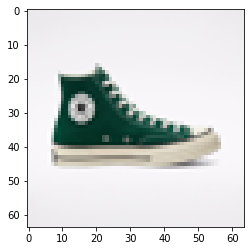

In [6]:
image_file_path = '/content/drive/MyDrive/GoogleColab/MiniProject/Shoes_imageDataList'
model_name = 'shoes_model.h5'
test_image_path = '/content/drive/MyDrive/GoogleColab/MiniProject/test'
categories = ['Other-Sneakers', '나이키-Running', '반스-Canvas', '슈펜-Canvas', '아디다스-Running', '아식스-Running', '엑셀시오르-Canvas', '컨버스-Canvas', '프로스펙스-Running', '휠라-Running']
review_file_path = '/content/drive/MyDrive/GoogleColab/MiniProject/review'
# 이미지 파일이 저장된 경로
# 학습된 모델 이름
# 테스트할 이미지의 저장 경로
# 전체 '브랜드-종류' 카테고리의 리스트
# 리뷰가 저장된 파일 경로

final_function(image_file_path, model_name, test_image_path, categories, review_file_path)